In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('dataset.csv')
df.head()

,Mean Atomic Number,Max Atomic Number,Min Atomic Number,Std Atomic Number,Density,Lattice Parameter a,Lattice Parameter b,Lattice Parameter c,Lattice Angle α,Lattice Angle β,...,Space Group 222,Space Group 223,Space Group 224,Space Group 225,Space Group 226,Space Group 227,Space Group 228,Space Group 229,band_gap,mpid
0,25.2,89,8,31.958723,11.490283,90.000000,90.0,90.0,0.2,2.040034,...,0,0,0,0,0,0,0,0,4.1024,mp-1183115
1,23.6,89,5,32.720636,10.309625,90.000000,90.0,90.0,0.2,1.967621,...,0,0,0,0,0,0,0,0,0.8071,mp-1183052
2,27.4,89,8,31.417193,12.272569,90.000000,90.0,90.0,0.4,2.085318,...,0,0,0,0,0,0,0,0,2.0031,mp-866101
3,28.4,89,8,31.372600,11.985877,90.000000,90.0,90.0,0.4,2.068944,...,0,0,0,0,0,0,0,0,0.0000,mp-864606
4,27.8,89,8,31.384072,12.359462,90.000092,90.0,90.0,0.4,2.090224,...,0,0,0,0,0,0,0,0,0.9888,mp-861502


In [ ]:
df.shape

(4555, 329)

### Filter Perovskite structures
Using Structure Features
If you have the lattice parameters (a, b, c) and lattice angles, you could implement some heuristics that are often associated with perovskites:

The a = b ≠ c condition is typically true for perovskites, as well as the specific lattice angles for cubic or orthorhombic symmetry.

The space group of perovskite depends on its structure:
1. Cubic perovskites: The space group for cubic perovskites is Pm3m (221).
2. Orthorhombic perovskites: The space group for orthorhombic perovskites is Pbnm (62). For example, CaTiO3 crystallizes in the orthorhombic Pnma space group

In [ ]:
# List of relevant space groups for perovskites
perovskite_space_groups = [62, 221, 225, 166]  # Add more if needed

# Create a list of columns to keep
columns_to_keep = ['Space Group ' + str(i) for i in perovskite_space_groups]

# Drop all columns that are not in the list of relevant space groups
columns_to_drop = [col for col in df.columns if col.startswith('Space Group') and col not in columns_to_keep]

# Drop the unwanted columns
df_cleaned = df.drop(columns=columns_to_drop)

In [ ]:
# Apply the filter based on space group and lattice parameters a=b!=c or a!=b!=c
perovskite_df = df_cleaned[
    (
        df_cleaned[['Space Group ' + str(i) for i in perovskite_space_groups]].sum(axis=1) > 0  # Check for matching space groups
    ) &
    (
        # Case 1: Tetragonal (a = b != c)
        ((df_cleaned['Lattice Parameter a'] == df_cleaned['Lattice Parameter b']) &
         (df_cleaned['Lattice Parameter c'] != df_cleaned['Lattice Parameter a']))
        |
        # Case 2: Orthorhombic/Triclinic (a != bS != c)
        ((df_cleaned['Lattice Parameter a'] != df_cleaned['Lattice Parameter b']) &
         (df_cleaned['Lattice Parameter a'] != df_cleaned['Lattice Parameter c']) &
         (df_cleaned['Lattice Parameter b'] != df_cleaned['Lattice Parameter c']))
    )
]

# Display the first few rows of the filtered DataFrame
perovskite_df.head()

,Mean Atomic Number,Max Atomic Number,Min Atomic Number,Std Atomic Number,Density,Lattice Parameter a,Lattice Parameter b,Lattice Parameter c,Lattice Angle α,Lattice Angle β,...,Mean Average Anionic Radius,Max Average Anionic Radius,Min Average Anionic Radius,Std Average Anionic Radius,Space Group 62,Space Group 166,Space Group 221,Space Group 225,band_gap,mpid
14,38.4,47,16,12.126005,24.244352,90.000000,90.000000,91.050713,0.6,3.935832,...,0.863055,0,0,0,1,0,0,0,0.2964,mp-1105645
29,30.0,79,8,28.781939,15.555074,90.000000,90.000000,108.919031,0.4,3.221612,...,0.617271,0,0,0,1,0,0,0,0.0000,mp-752678
31,15.2,47,5,15.942396,21.612905,48.159219,48.159219,48.159224,0.2,2.333754,...,0.617271,0,0,0,0,1,0,0,0.0000,mp-780275
36,15.4,47,6,15.818976,21.939282,48.627516,48.627513,48.627502,0.2,2.340312,...,0.617271,0,0,0,0,1,0,0,0.0000,mp-753176
58,23.4,47,8,18.863722,14.346448,90.000000,90.000000,111.152674,0.4,3.104676,...,0.617271,0,0,0,1,0,0,0,0.0000,mp-776166


In [ ]:
perovskite_df.shape

(174, 106)

In [ ]:
# df = perovskite_df

In [ ]:
df.head(30)

,Mean Atomic Number,Max Atomic Number,Min Atomic Number,Std Atomic Number,Density,Lattice Parameter a,Lattice Parameter b,Lattice Parameter c,Lattice Angle α,Lattice Angle β,...,Space Group 222,Space Group 223,Space Group 224,Space Group 225,Space Group 226,Space Group 227,Space Group 228,Space Group 229,band_gap,mpid
0,25.2,89,8,31.958723,11.490283,90.000000,90.000000,90.000000,0.2,2.040034,...,0,0,0,0,0,0,0,0,4.1024,mp-1183115
1,23.6,89,5,32.720636,10.309625,90.000000,90.000000,90.000000,0.2,1.967621,...,0,0,0,0,0,0,0,0,0.8071,mp-1183052
2,27.4,89,8,31.417193,12.272569,90.000000,90.000000,90.000000,0.4,2.085318,...,0,0,0,0,0,0,0,0,2.0031,mp-866101
3,28.4,89,8,31.372600,11.985877,90.000000,90.000000,90.000000,0.4,2.068944,...,0,0,0,0,0,0,0,0,0.0000,mp-864606
4,27.8,89,8,31.384072,12.359462,90.000092,90.000000,90.000000,0.4,2.090224,...,0,0,0,0,0,0,0,0,0.9888,mp-861502
5,28.8,89,8,31.390444,12.291016,90.000000,90.000000,90.000000,0.2,2.086362,...,0,0,0,0,0,0,0,0,2.8959,mp-1183053
6,25.0,89,8,32.037478,12.956751,90.000000,90.000000,90.000000,0.4,2.123371,...,0,0,0,0,0,0,0,0,0.0000,mp-1183142
7,27.6,89,8,31.398089,12.448280,90.000000,90.000000,90.000000,0.4,2.095223,...,0,0,0,0,0,0,0,0,0.0000,mp-864911
8,28.2,89,8,31.371324,11.671644,90.000000,90.000000,90.000000,0.4,2.050711,...,0,0,0,0,0,0,0,0,0.0000,mp-1183139
9,31.8,89,8,32.164577,13.337335,90.000000,90.000000,90.000000,0.4,2.143961,...,0,0,0,0,0,0,0,0,0.0000,mp-1183145


In [ ]:
# Method 2: Using df.columns.tolist() (slightly more explicit)
all_columns_list = df.columns.tolist()
all_columns_list

['Mean Atomic Number',
 'Max Atomic Number',
 'Min Atomic Number',
 'Std Atomic Number',
 'Density',
 'Lattice Parameter a',
 'Lattice Parameter b',
 'Lattice Parameter c',
 'Lattice Angle α',
 'Lattice Angle β',
 'Lattice Angle γ',
 'Metals Fraction',
 'Mean Distance',
 'Max Distance',
 'Min Distance',
 'Std Distance',
 'Mean Van der Waals Radius',
 'Max Van der Waals Radius',
 'Min Van der Waals Radius',
 'Std Van der Waals Radius',
 'Mean Electrical Resistivity',
 'Max Electrical Resistivity',
 'Min Electrical Resistivity',
 'Std Electrical Resistivity',
 'Mean Velocity of Sound',
 'Max Velocity of Sound',
 'Min Velocity of Sound',
 'Std Velocity of Sound',
 'Mean Reflectivity',
 'Max Reflectivity',
 'Min Reflectivity',
 'Std Reflectivity',
 "Mean Poisson's Ratio",
 "Max Poisson's Ratio",
 "Min Poisson's Ratio",
 "Std Poisson's Ratio",
 'Mean Molar Volume',
 'Max Molar Volume',
 'Min Molar Volume',
 'Std Molar Volume',
 'Mean Thermal Conductivity',
 'Max Thermal Conductivity',
 'Min

In [ ]:
zero_counts = (df == 0).sum()
zero_counts

,0
Mean Atomic Number,0
Max Atomic Number,0
Min Atomic Number,0
Std Atomic Number,0
Density,0
...,...
Space Group 227,4555
Space Group 228,4555
Space Group 229,4555
band_gap,2333


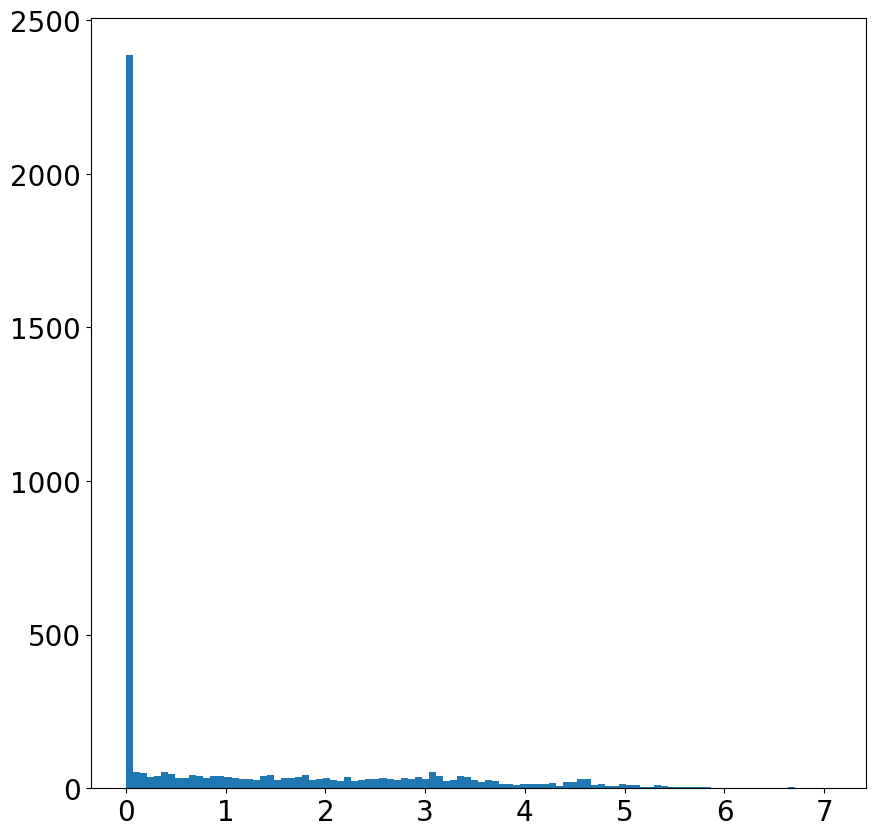

In [ ]:
plt.rcParams.update({'font.size': 20})

plt.figure(figsize=(10, 10))
plt.hist(df['band_gap'], bins=100)
plt.savefig('Histogram_PDF', bbox_inches='tight')

This plot shows that amost half of our structures are metals (zero bandgap). The bandgaps around 7 eV could be outliers, but we can deal with those in a later.

How about a scatter plot?

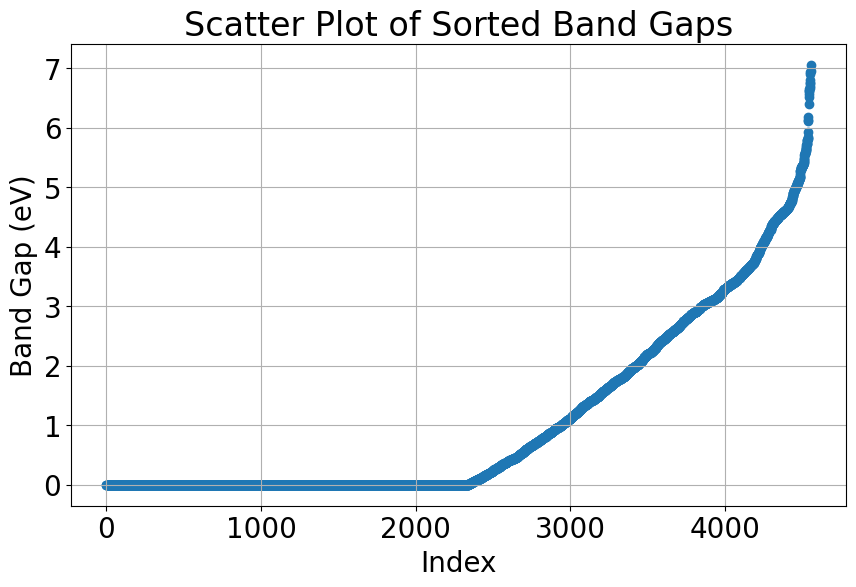

In [ ]:
# Sort the DataFrame by band gap values
df_sorted = df.sort_values('band_gap')

# Extract the sorted band gap values
sorted_bandgaps = df_sorted['band_gap'].values

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(sorted_bandgaps)), sorted_bandgaps)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Scatter Plot of Sorted Band Gaps')
plt.grid(True)
plt.show()

### The machine learning task

In [ ]:
df.describe()

,Mean Atomic Number,Max Atomic Number,Min Atomic Number,Std Atomic Number,Density,Lattice Parameter a,Lattice Parameter b,Lattice Parameter c,Lattice Angle α,Lattice Angle β,...,Space Group 221,Space Group 222,Space Group 223,Space Group 224,Space Group 225,Space Group 226,Space Group 227,Space Group 228,Space Group 229,band_gap
count,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,...,4555.0,4555.000000,4555.0,4555.000000,4555.0,4555.000000,4555.0,4555.0,4555.0,4555.000000
mean,25.094050,53.460373,10.567947,16.972583,21.416872,88.162167,89.350626,90.376535,0.338134,3.090680,...,0.0,0.002195,0.0,0.005928,0.0,0.002634,0.0,0.0,0.0,1.082965
std,11.379457,20.812491,8.209779,8.406732,22.540253,14.954579,14.599581,17.967837,0.166684,1.086130,...,0.0,0.046809,0.0,0.076771,0.0,0.051265,0.0,0.0,0.0,1.536337
min,2.000000,4.000000,1.000000,0.800000,6.230643,23.012565,23.012565,21.870109,0.000000,1.339242,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
25%,17.000000,37.000000,7.000000,9.830565,12.636798,89.999961,90.000000,90.000000,0.200000,2.259432,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
50%,23.000000,55.000000,8.000000,16.560193,16.123360,90.000000,90.000000,90.000000,0.400000,2.924231,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
75%,31.200000,69.000000,9.000000,23.650793,24.531591,90.000000,90.000000,90.000000,0.400000,3.496302,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,1.982550
max,81.600000,94.000000,79.000000,42.625814,744.177285,152.548175,160.938873,158.938715,1.000000,14.325985,...,0.0,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,7.061300


In [ ]:
df.columns

Index(['Mean Atomic Number', 'Max Atomic Number', 'Min Atomic Number',
       'Std Atomic Number', 'Density', 'Lattice Parameter a',
       'Lattice Parameter b', 'Lattice Parameter c', 'Lattice Angle α',
       'Lattice Angle β',
       ...
       'Space Group 222', 'Space Group 223', 'Space Group 224',
       'Space Group 225', 'Space Group 226', 'Space Group 227',
       'Space Group 228', 'Space Group 229', 'band_gap', 'mpid'],
      dtype='object', length=329)

In [ ]:

# Remove rows where 'band_gap' is 0 or above 5.7
df = df[(df['band_gap'] > 0) & (df['band_gap'] < 5.7)]

In [ ]:
df.shape

(2193, 329)

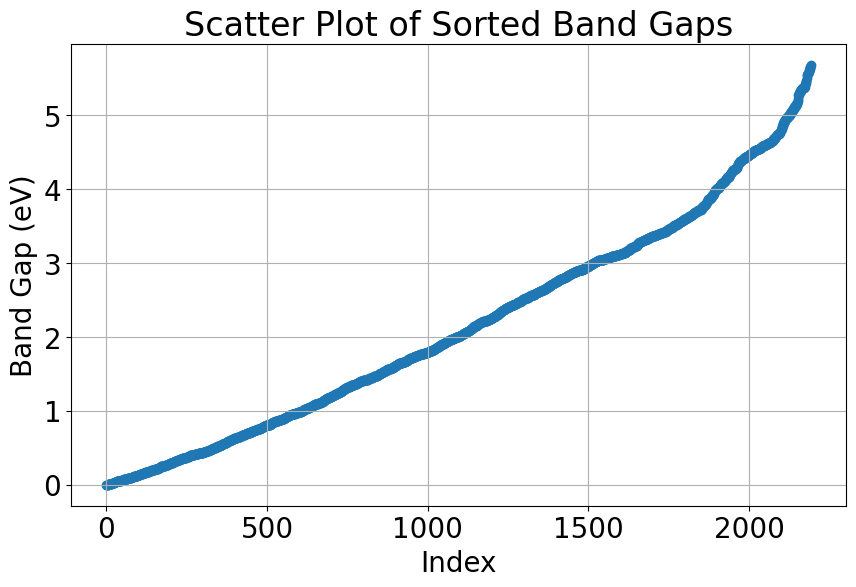

In [ ]:
# Sort the DataFrame by band gap values
df_sorted = df.sort_values('band_gap')

# Extract the sorted band gap values
sorted_bandgaps = df_sorted['band_gap'].values

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(sorted_bandgaps)), sorted_bandgaps)
plt.xlabel('Index')
plt.ylabel('Band Gap (eV)')
plt.title('Scatter Plot of Sorted Band Gaps')
plt.grid(True)
plt.show()

In [ ]:
# Define features and target
X = df.drop(columns=['band_gap','mpid'])
y = df['band_gap']

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize the model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=100)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Performance Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb)}")
print(f"R^2: {r2_score(y_test, y_pred_xgb)}")

XGBoost Performance Metrics:
MAE: 0.5512717372209627
MSE: 0.6626350191546932
R^2: 0.6891650971980299


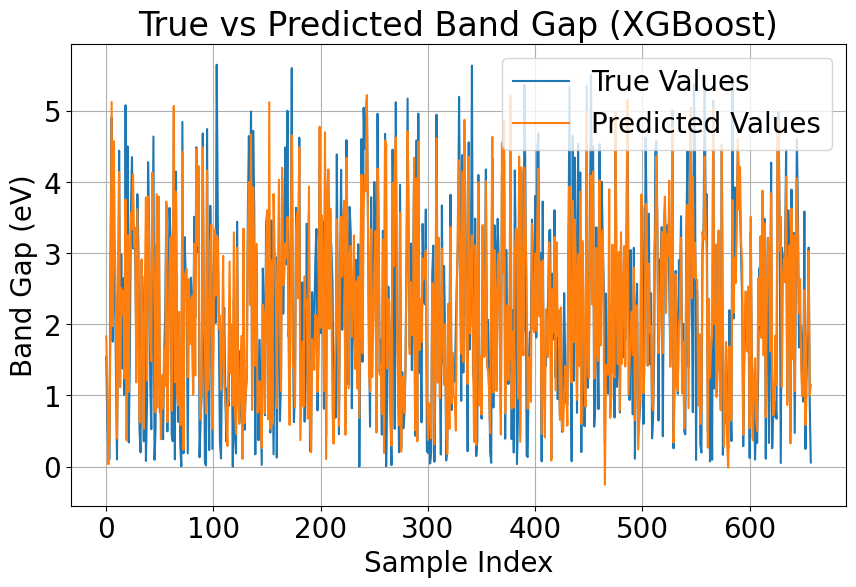

In [ ]:
# Assuming y_test and y_pred_xgb are already defined from your previous code
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred_xgb, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Band Gap (eV)')
plt.title('True vs Predicted Band Gap (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

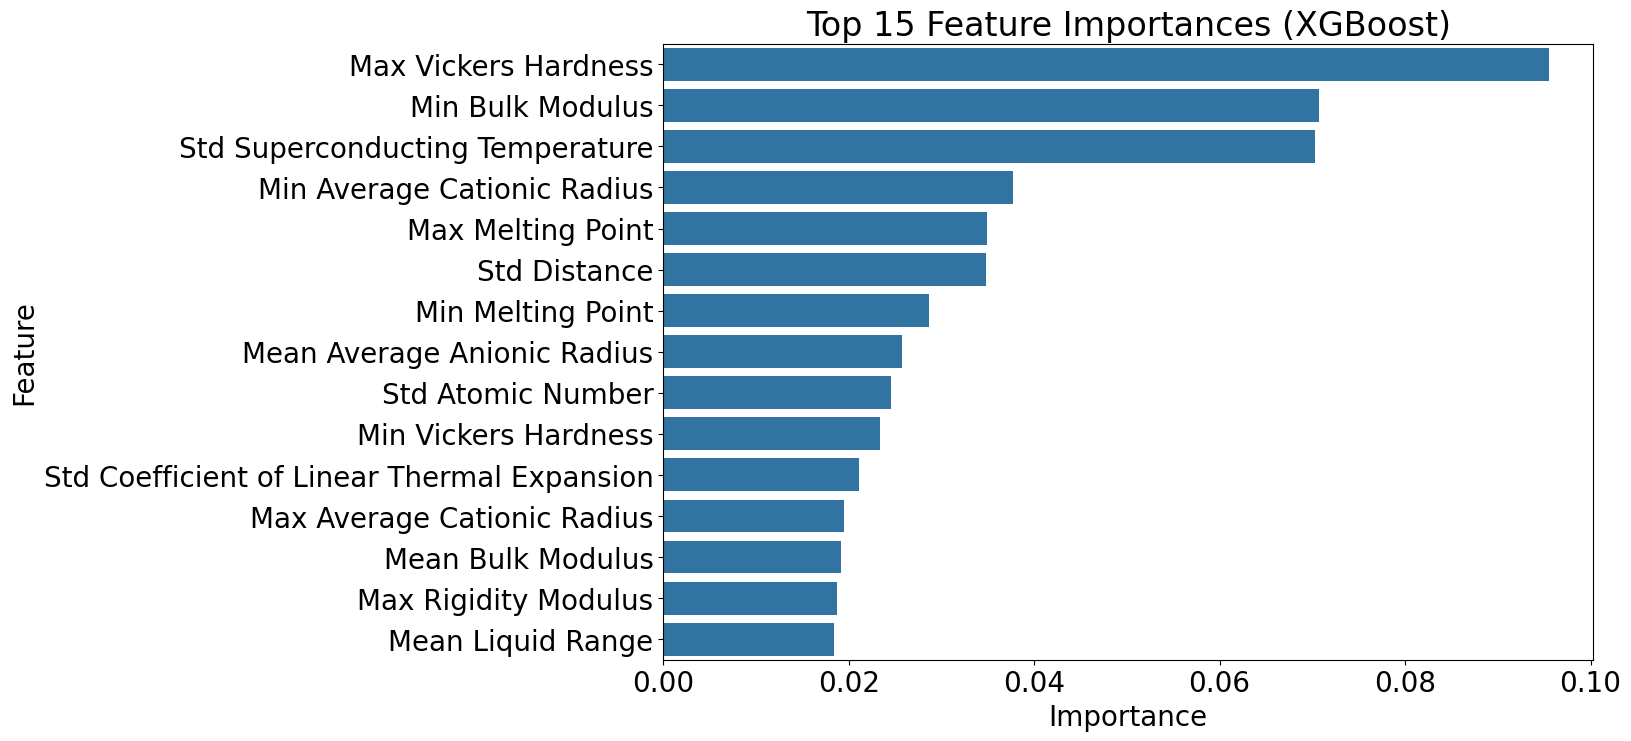

In [ ]:
# prompt: plot feature importance of top 15 features

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'xgb_model' is your trained XGBoost model and 'X' are your features
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier sorting and plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

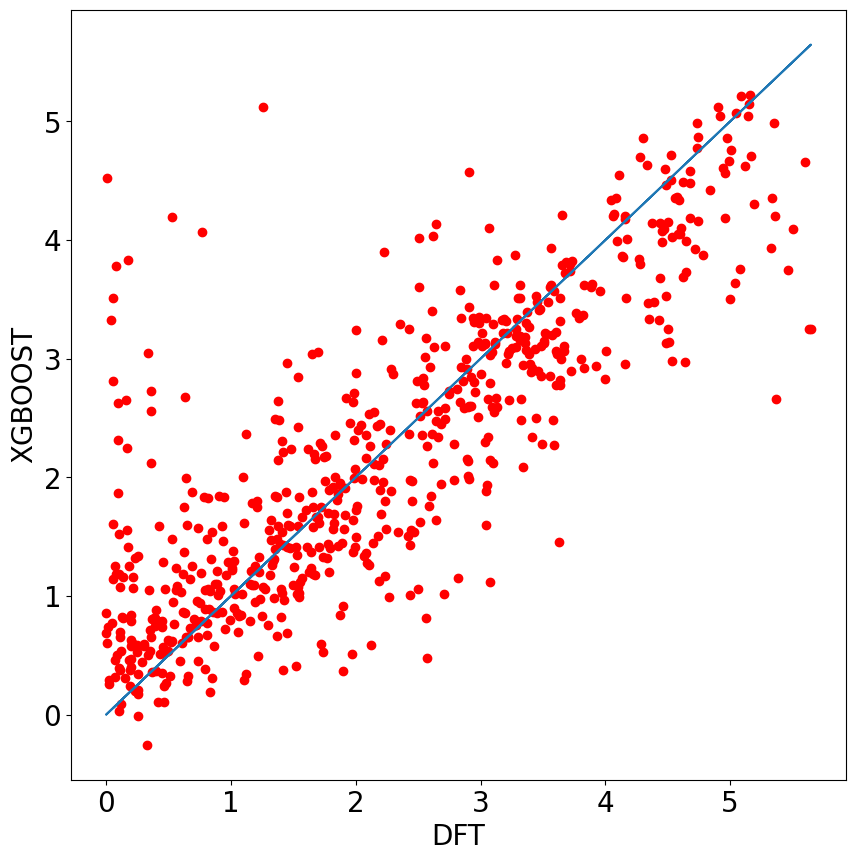

In [ ]:
xPlot=y_test
yPlot=y_pred_xgb
plt.figure(figsize=(10,10))
plt.plot(xPlot,yPlot,'ro')
plt.plot(xPlot,xPlot)
plt.ylabel('XGBOOST')
plt.xlabel('DFT')
plt.savefig('XGBOOST_Correlation_Test', bbox_inches='tight')

Random Forest Performance Metrics:
MAE: 0.6068503530679632
MSE: 0.726493749088099
R^2: 0.6592096593806489


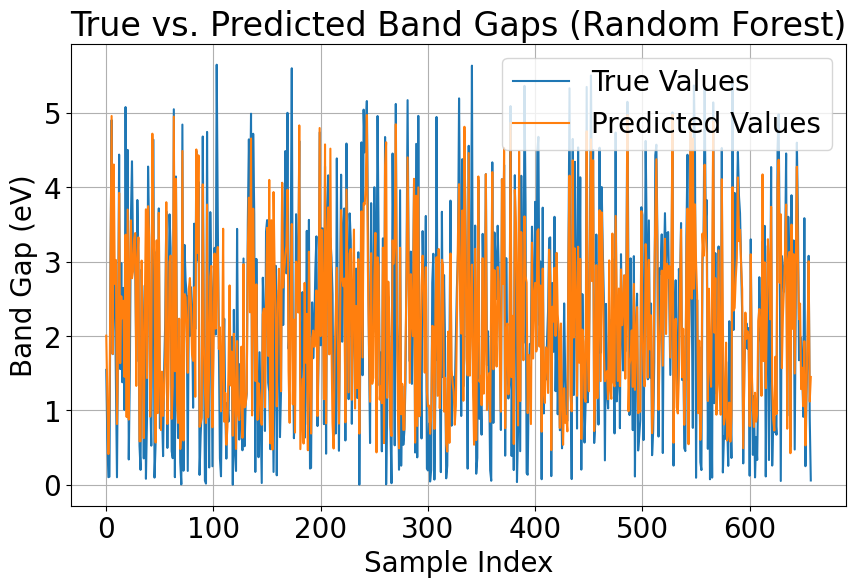

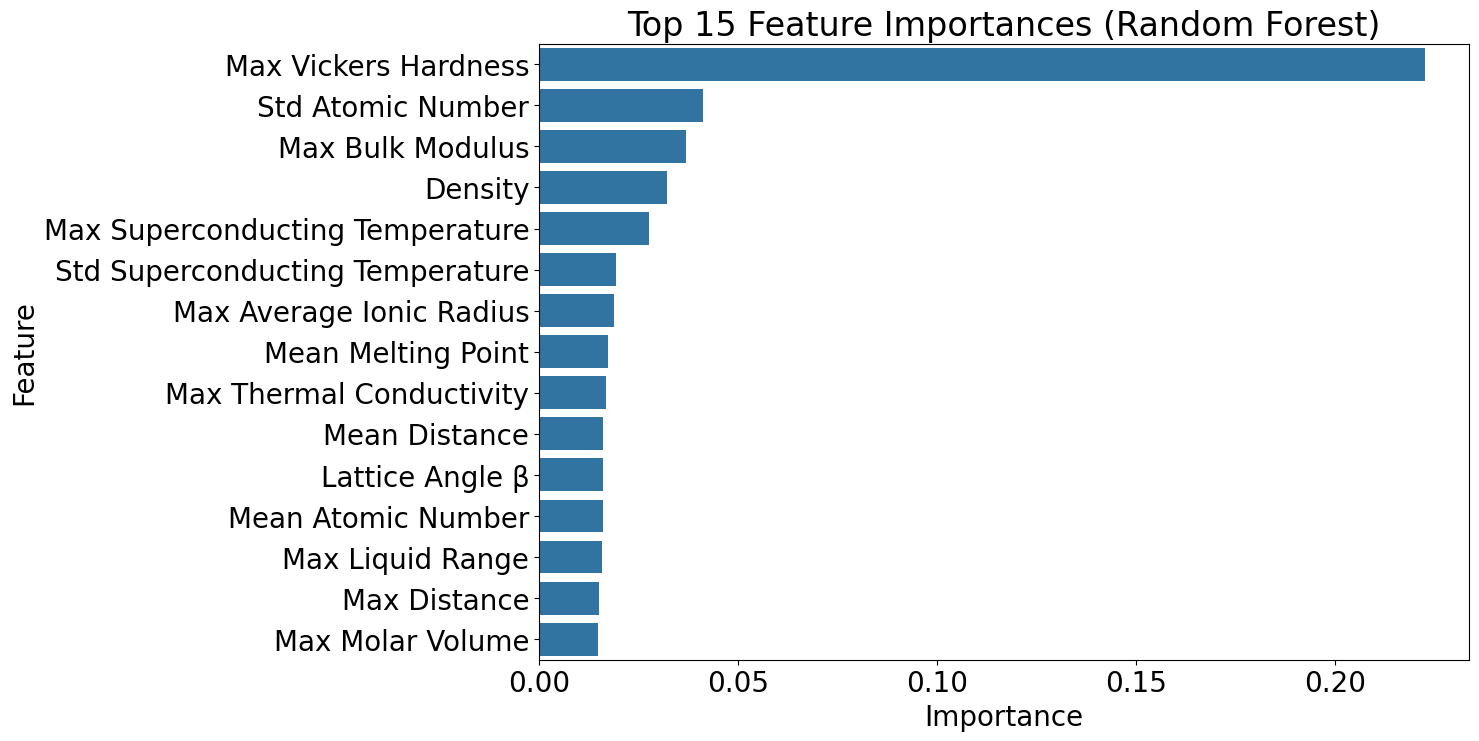

In [ ]:
# Initialize and train the RandomForestRegressor
rf_model = RandomForestRegressor(max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50)  # Pass hyperparameters as keyword arguments
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Performance Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred_rf)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"R^2: {r2_score(y_test, y_pred_rf)}")

# Plot the predictions vs. true values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values')
plt.plot(y_pred_rf, label='Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Band Gap (eV)')
plt.title('True vs. Predicted Band Gaps (Random Forest)')
plt.legend()
plt.grid(True)
plt.show()

# Feature Importance for Random Forest
feature_importance_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_rf})
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# # prompt: do hyper parameter tuning with random forest above

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Create a RandomForestRegressor
# rf_model = RandomForestRegressor(random_state=42)

# # Perform GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Get the best model and its hyperparameters
# best_rf_model = grid_search.best_estimator_
# print("Best Hyperparameters:", grid_search.best_params_)

# # Evaluate the best model
# y_pred_best_rf = best_rf_model.predict(X_test)
# print("Best Random Forest Performance Metrics:")
# print(f"MAE: {mean_absolute_error(y_test, y_pred_best_rf)}")
# print(f"MSE: {mean_squared_error(y_test, y_pred_best_rf)}")
# print(f"R^2: {r2_score(y_test, y_pred_best_rf)}")

# # Plot the predictions vs. true values for the best model
# plt.figure(figsize=(10, 6))
# plt.plot(y_test.values, label='True Values')
# plt.plot(y_pred_best_rf, label='Predicted Values')
# plt.xlabel('Sample Index')
# plt.ylabel('Band Gap (eV)')
# plt.title('True vs. Predicted Band Gaps (Best Random Forest)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
def predict_band_gap(mpid):
  """
  Predicts the band gap for a given MPID.

  Args:
    mpid: The Materials Project ID.

  Returns:
    The predicted band gap, or None if the MPID is not found.
  """
  try:
    # Find the corresponding row in the DataFrame based on MPID
    material_data = df[df['mpid'] == mpid]

    if material_data.empty:
      return None  # MPID not found in the dataset

    # Extract the features for the given MPID
    material_features = material_data.drop(columns=['band_gap', 'mpid'])

    # Make prediction using the loaded model
    predicted_band_gap = xgb_model.predict(material_features)[0]
    return predicted_band_gap
  except KeyError as e:
    print(f"Error: Missing feature '{e}' in the dataset. Check your data.")
    return None
  except Exception as e:
    print(f"An unexpected error occurred: {e}")
    return None

# Example usage
mpid_to_predict = "mp-4531" # Replace with an actual MPID
predicted_gap = predict_band_gap(mpid_to_predict)

if predicted_gap is not None:
  print(f"The predicted band gap for MPID {mpid_to_predict} is: {predicted_gap} eV")
else:
  print(f"MPID {mpid_to_predict} not found in the dataset.")

The predicted band gap for MPID mp-4531 is: 1.9584403038024902 eV


### DFT PART


In [ ]:
# # Assuming df and the trained xgb_model are available from the previous code

# # Sample 10 MPIDs
# sampled_mpids = df.sample(n=20, random_state=42)['mpid']

# import pandas as pd

# # ... (rest of your code) ...

# # Create a DataFrame to store the results
# results_df = pd.DataFrame(columns=['mpid', 'predicted_band_gap', 'actual_band_gap'])

# results_list = []  # Store results in a list first

# for mpid in sampled_mpids:
#     # Prepare the input features for prediction
#     mpid_data = df[df['mpid'] == mpid].drop(columns=['band_gap', 'mpid'])

#     # Predict the band gap using the trained model
#     predicted_band_gap = best_rf_model.predict(mpid_data)[0]

#     # Get the actual band gap
#     actual_band_gap = df[df['mpid'] == mpid]['band_gap'].iloc[0]

#     # Append the results to the list
#     results_list.append({'mpid': mpid,
#                          'predicted_band_gap': predicted_band_gap,
#                          'actual_band_gap': actual_band_gap})

# # Create the DataFrame from the list after the loop
# results_df = pd.DataFrame(results_list)

# results_df

In [ ]:
# # prompt: download results_df csv file

# from google.colab import files
# results_df.to_csv('results_df.csv', encoding = 'utf-8-sig')
# files.download('results_df.csv')


In [ ]:
df2 = pd.read_csv('results_df.csv')
df2

Index(['Mean Atomic Number', 'Max Atomic Number', 'Min Atomic Number',
       'Std Atomic Number', 'Density', 'Lattice Parameter a',
       'Lattice Parameter b', 'Lattice Parameter c', 'Lattice Angle α',
       'Lattice Angle β',
       ...
       'Mean Average Anionic Radius', 'Max Average Anionic Radius',
       'Min Average Anionic Radius', 'Std Average Anionic Radius',
       'Space Group 62', 'Space Group 166', 'Space Group 221',
       'Space Group 225', 'band_gap', 'mpid'],
      dtype='object', length=106)
Columns 'Unnamed: 0' and 'Unnamed: 5' not found in the DataFrame.


In [ ]:
df2 = df2.drop(columns=['Unnamed: 0', 'Unnamed: 5'], axis = 1)

In [ ]:
df2.head(11)

,mpid,predicted_band_gap,actual_band_gap,DFT_self
0,mp-2998,1.349100,1.6118,1.3491
1,mp-9890,1.845624,1.8552,1.8552
2,mp-1105645,0.296400,0.2917,0.2917
3,mp-1205548,3.999300,3.7853,3.7853
4,mp-1205521,3.441131,3.7234,3.7192
5,mp-866850,0.452786,0.4247,0.4211
6,mp-27552,2.314570,2.1427,2.1425
7,mp-756705,4.383200,4.0582,4.0377
8,mp-7607,1.681900,1.1470,1.3528
9,mp-38035,4.201900,4.6569,4.6571


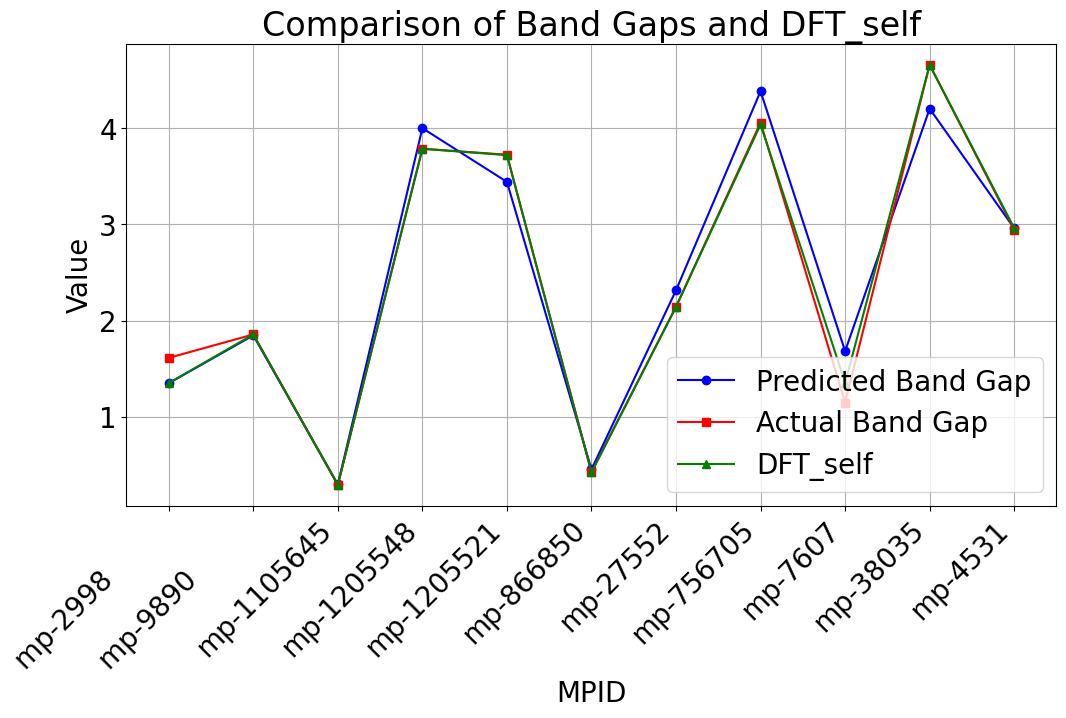

In [ ]:
# prompt: plot predicted_band_gap, actual_band_gap and DFE_self with respect to mpid of each row and give different colour to all

import matplotlib.pyplot as plt

# Assuming df2 is your DataFrame with 'mpid', 'predicted_band_gap', 'actual_band_gap', and 'DFE_self' columns
# Replace 'DFE_self' with the actual column name if it's different

plt.figure(figsize=(12, 6))

# Plot predicted_band_gap
plt.plot(df2['mpid'], df2['predicted_band_gap'], marker='o', linestyle='-', color='blue', label='Predicted Band Gap')

# Plot actual_band_gap
plt.plot(df2['mpid'], df2['actual_band_gap'], marker='s', linestyle='-', color='red', label='Actual Band Gap')

# Plot DFE_self (assuming it's a column in df2)
plt.plot(df2['mpid'], df2['DFT_self'], marker='^', linestyle='-', color='green', label='DFT_self')


plt.xlabel('MPID')
plt.ylabel('Value')
plt.title('Comparison of Band Gaps and DFT_self')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
 # Adjust layout to prevent labels from overlapping
plt.show()